# Agentic Marketing Analytics — 5-Minute Demo

**Goal**: Take a plain-English marketing question → triage → text-to-SQL (template-first) → run in DuckDB → plot → 2-sentence summary

**Key principles**:
- Semantic/model layer only (no raw table access)
- Template-first (no open-ended prompts)
- Visible guardrails and observability
- Fail closed with friendly errors

## Cell 1: Bootstrap & Validation

Load configs, connect to DuckDB (read-only), and validate schema.

In [49]:
from pathlib import Path
import os, json, yaml, time
import duckdb, pandas as pd
import matplotlib.pyplot as plt
import sys
from dotenv import load_dotenv

ROOT = Path.cwd().parents[0] if Path.cwd().name=="notebooks" else Path.cwd()
CFG  = ROOT/"config"

# Load environment variables from .env file
load_dotenv(ROOT / ".env")
print("✅ Environment variables loaded from .env")

# Add core modules to path
sys.path.insert(0, str(ROOT))
from core.llm_clients import LLMClient

DB   = yaml.safe_load(open(CFG/"db.yaml"))
SCHEMA = json.load(open(CFG/"schema.json"))
BIZ   = yaml.safe_load(open(CFG/"business_context.yaml"))
TMPL  = yaml.safe_load(open(CFG/"sql_templates.yaml"))
PROMPT_TMPL = yaml.safe_load(open(CFG/"prompt_templates.yaml"))

# Resolve database path relative to ROOT (handle relative paths like ./data/foo.duckdb)
db_path_str = DB["duckdb_path"]
if db_path_str.startswith("./"):
    db_path = ROOT / db_path_str[2:]  # Strip ./ and resolve from ROOT
else:
    db_path = Path(db_path_str)
    if not db_path.is_absolute():
        db_path = ROOT / db_path

con = duckdb.connect(database=str(db_path), read_only=True)
print(f"📁 Connected to: {db_path}")

def _tables(): return [r[0] for r in con.execute("SHOW TABLES").fetchall()]
def _cols(t): return {r[1]: r[2] for r in con.execute(f"PRAGMA table_info({t})").fetchall()}

missing=[]
for t, cols in SCHEMA.items():
    if t not in _tables(): missing.append(f"Missing table {t}"); continue
    act=_cols(t)
    for c in cols.keys():
        if c not in act: missing.append(f"Missing column {t}.{c}")
assert not missing, "Schema check failed:\n- "+"\n- ".join(missing)
print("✅ Schema OK, DB connected (read-only)")

✅ Environment variables loaded from .env
📁 Connected to: /Users/thomas/Documents/GitHub/tasman-marketing-agent/data/synthetic_data.duckdb
✅ Schema OK, DB connected (read-only)


## Cell 2: Helper Functions

Minimal inline helpers for the demo:
- `triage_local()`: Rule-based classification (search vs analysis)
- `match_template()`: Match question to SQL template
- `run_sql()`: Execute with safety checks
- `read_only_ok()`: SQL safety validator

In [50]:
DEFAULTS = {
    "limit": DB.get("default_limit", 1000),
    "window": BIZ.get("defaults", {}).get("time_window_days", 90)
}

def ensure_limit(sql, lim=DEFAULTS["limit"]):
    s=sql.strip().rstrip(";")
    # Check for LIMIT clause (case-insensitive, handles newlines/spaces)
    import re
    if re.search(r'\blimit\b', s, re.IGNORECASE):
        return s + ";"
    return f"{s}\nLIMIT {lim};"

PROHIBITED = ("insert ","update ","delete ","create ","alter ","drop ","truncate ","merge ")
def read_only_ok(sql):
    s=sql.strip().lower()
    # Allow SELECT and WITH (CTEs) statements only
    starts_safe = s.startswith("select ") or s.startswith("with ")
    has_prohibited = any(k in s for k in PROHIBITED)
    return starts_safe and not has_prohibited

def triage_local(question:str):
    q=question.lower()
    search_kw = ("what","show","list","plot","how much","how many","roas","spend","ctr","cvr","orders","revenue")
    analysis_kw=("why","driver","impact","hypothesis","test","causal","effect")
    score = 0.6 if any(k in q for k in search_kw) else 0.2
    if any(k in q for k in analysis_kw): score = 0.3
    mode = "search" if score>=0.5 else "analysis"
    return {"mode":mode,"confidence":round(score,2),"reason":"keyword rules"}

def match_template(question:str, role="marketer", window_days=None):
    window_days = window_days or DEFAULTS["window"]
    q=question.lower()
    for t in TMPL:
        role_hint = t.get("role_hint")
        # Support both single role and list of roles
        if isinstance(role_hint, list):
            role_match = role in role_hint
        else:
            role_match = role_hint == role
            
        if role_match:
            for utt in t.get("utterances",[]):
                if utt in q:
                    sql=t["sql"].replace("{{time_window_days}}", str(window_days)).replace("{{limit}}", str(DEFAULTS["limit"]))
                    return {"id":t["id"], "sql":sql, "source":"template"}
    return None

def run_sql(sql:str):
    assert read_only_ok(sql), "Blocked non-SELECT SQL"
    sql=ensure_limit(sql)
    t0=time.time()
    df=con.execute(sql).df()
    return df, {"rows":len(df), "ms":int((time.time()-t0)*1000)}

def format_data_summary(df: pd.DataFrame, max_rows: int = 10) -> str:
    """Format dataframe for LLM analysis."""
    summary = f"Shape: {df.shape[0]} rows x {df.shape[1]} columns\n\n"
    summary += "Columns: " + ", ".join(df.columns) + "\n\n"
    summary += "Top rows:\n"
    summary += df.head(max_rows).to_string(index=False)
    return summary

def generate_llm_insight(question: str, df: pd.DataFrame, role: str, llm_client: LLMClient) -> str:
    """Generate role-specific insight using LLM."""
    role_config = BIZ.get('roles', {}).get(role, {})
    kpis = ", ".join(role_config.get('kpis', []))
    dims = ", ".join(role_config.get('dims', []))
    time_window = role_config.get('defaults', {}).get('time_window_days', DEFAULTS['window'])
    
    # Format prompts from template
    system_tmpl = PROMPT_TMPL['insight_generation']['system']
    user_tmpl = PROMPT_TMPL['insight_generation']['user']
    
    system_prompt = system_tmpl.format(
        role=role,
        kpis=kpis,
        dims=dims,
        time_window_days=time_window
    )
    
    user_prompt = user_tmpl.format(
        question=question,
        data_summary=format_data_summary(df),
        role=role
    )
    
    response = llm_client.call(
        system_prompt,
        user_prompt,
        cache_key_parts=("insight", question, role, str(df.shape))
    )
    
    return response

print("✅ Helper functions loaded")

✅ Helper functions loaded


## Cell 3: Question Input + LLM Toggle

**This is the only cell you type live during the demo.**

**Demo Options:**

**Option 1 - Marketer (tactical, 90 days)**
```python
user_role = "marketer"
user_question = "Show ROAS by channel for the last 90 days and plot it"
```
*LLM focuses on: Campaign optimization, channel efficiency, tactical adjustments*

**Option 2 - CEO (strategic, 180 days)**
```python
user_role = "ceo"
user_question = "Show ROAS by channel and plot it"
```
*LLM focuses on: Revenue growth potential, strategic budget allocation, incremental revenue from marketing spend optimization*

**LLM Analysis**: Set `USE_LLM_INSIGHT = True` to enable AI-powered, role-specific insights (max 4 lines). The LLM receives:
- Query results as formatted data
- Role context (KPIs, dimensions, time horizon)
- Role-specific guidance (CEO gets revenue growth focus)
- Prompt template from `config/prompt_templates.yaml`

**Requirements**: Add to your `.env` file in the project root:
```
ANTHROPIC_API_KEY=your_key_here
# OR
OPENAI_API_KEY=your_key_here
```

The notebook automatically loads environment variables from `.env` on startup.

In [52]:
# DEMO CONFIGURATION
# Change these to switch between roles and perspectives

# Option 1: Marketer (tactical, 90 days)
# user_role = "marketer"
# user_question = "Show ROAS by channel for the last 90 days and plot it"

# Option 2: CEO (strategic, 180 days) - Uncomment to use
user_role = "marketer"
user_question = "Show ROAS by channel and plot it"

# LLM Analysis Toggle (set to True to enable AI-powered insights)
USE_LLM_INSIGHT = True

# Get time window for this role (marketer=90 days, ceo=180 days)
role_config = BIZ.get('roles', {}).get(user_role, {})
time_window = role_config.get('defaults', {}).get('time_window_days', DEFAULTS['window'])
print(f"🎯 Role: {user_role.upper()}")
print(f"⏱️  Time horizon: {time_window} days")

# Initialize LLM client (only if enabled)
if USE_LLM_INSIGHT:
    # Defaults to Anthropic (Claude Haiku) - set ANTHROPIC_API_KEY in .env
    # Use provider="openai" for GPT-4o-mini - set OPENAI_API_KEY in .env
    llm = LLMClient(
        provider="openai",
        cache_dir=ROOT / ".cache" / "llm",
        temperature=0.3,
        max_tokens=300
    )
    print("✅ LLM client initialized (Anthropic/Claude Haiku)")

🎯 Role: CEO
⏱️  Time horizon: 180 days
✅ LLM client initialized (Anthropic/Claude Haiku)


## Cell 4: Agent Flow

**End-to-end execution**: Triage → Template → SQL → Run → Visualize → Summarize → Observability

This is the core demo showing:
1. Rule-based triage (search vs analysis)
2. Template matching (bound to semantic layer)
3. SQL execution with guardrails
4. Auto-visualization
5. 2-sentence summary
6. Observability logs

🔎 Triage -> {'mode': 'search', 'confidence': 0.6, 'reason': 'keyword rules'}
🧩 Template -> roas_by_channel
⏱️  Using 180-day window for ceo role

📊 Results: 4 rows in 287ms


,channel,spend,revenue,roas
0,snapchat,1637049.88,1.115637e+07,6.814925
1,meta,6491176.63,3.593069e+07,5.535313
2,google_shopping,1457079.95,7.290178e+06,5.003280
3,google_search,8105673.18,3.324572e+07,4.101538


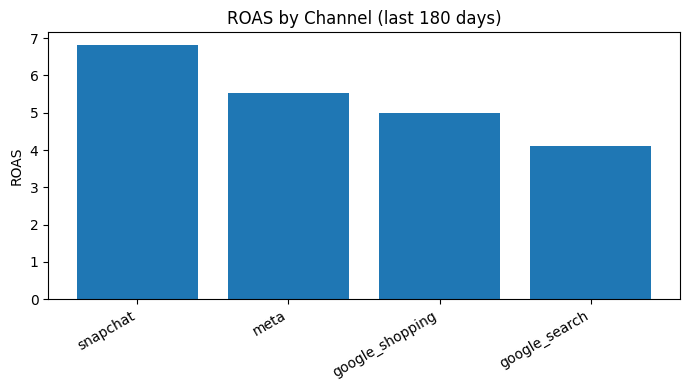


📊 Quick Summary: Top ROAS channel is **snapchat** at ~6.81. Consider shifting a small test budget towards it with guardrails.

🤖 AI-Powered Analysis for CEO (max 4 lines)
Snapchat leads with a ROAS of 6.81, significantly outperforming other channels. Meta and Google Shopping also show strong returns, but Google Search lags at 4.10. To maximize revenue growth, consider reallocating budget from Google Search to Snapchat, which could enhance overall channel efficiency and drive incremental revenue.

📋 Observability Log


{'triage': {'mode': 'search', 'confidence': 0.6, 'reason': 'keyword rules'},
 'exec': {'rows': 4, 'ms': 287},
 'llm_insight': 'Snapchat leads with a ROAS of 6.81, significantly outperforming other channels. Meta and Google Shopping also show strong returns, but Google Search lags at 4.10. To maximize revenue growth, consider reallocating budget from Google Search to Snapchat, which could enhance overall channel efficiency and drive incremental revenue.',
 'sql': "WITH spend AS (\n  SELECT c.channel, SUM(f.spend) AS spend\n  FROM fact_ad_spend f\n  JOIN dim_campaigns c ON f.campaign_id = c.campaign_id\n  WHERE f.date >= CURRENT_DATE - INTERVAL '180' DAYS\n  GROUP BY 1\n),\nrev AS (\n  SELECT c.channel, SUM(o.revenue) AS revenue\n  FROM fact_orders o\n  JOIN fact_sessions s ON o.session_id = s.session_id\n  JOIN dim_campaigns c ON s.campaign_id = c.campaign_id\n  WHERE o.order_timestamp >= (CURRENT_TIMESTAMP - INTERVAL '180' DAYS)::TIMESTAMP\n  GROUP BY 1\n)\nSELECT COALESCE(spend.channe

In [53]:
OBS = {}

# 1. Triage
tri = triage_local(user_question)
OBS["triage"] = tri
print("🔎 Triage ->", tri)

assert tri["mode"]=="search", "Demo path is 'search'; choose a search-style question."

# 2. Template mapping (use role-specific time window)
mt = match_template(user_question, role=user_role, window_days=time_window)
assert mt, "No template matched; pick the backup question."
print(f"🧩 Template -> {mt['id']}")
print(f"⏱️  Using {time_window}-day window for {user_role} role")

# 3. Execute
df, exec_meta = run_sql(mt["sql"])
OBS["exec"] = exec_meta
print(f"\n📊 Results: {exec_meta['rows']} rows in {exec_meta['ms']}ms")
display(df.head(8))

# 4. Visualize
assert df.shape[0]>0, "Empty result; adjust time window or use backup question."
fig = plt.figure(figsize=(7,4))
if {"channel","roas"} <= set(c.lower() for c in df.columns):
    # Normalize columns for robustness
    cols = {c.lower(): c for c in df.columns}
    x = df[cols.get("channel")]
    y = df[cols.get("roas")]
    plt.bar(x, y)
    plt.title(f"ROAS by Channel (last {time_window} days)")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("ROAS")
    plt.tight_layout()
elif {"date","total_spend"} <= set(c.lower() for c in df.columns):
    cols = {c.lower(): c for c in df.columns}
    plt.plot(df[cols.get("date")], df[cols.get("total_spend")])
    plt.title("Spend by Channel Over Time")
    plt.tight_layout()
else:
    plt.plot(df.iloc[:,0], df.iloc[:, -1]); plt.title("Auto plot")
plt.show()

# 5. Summary (rule-based, 2 lines max)
def short_summary(d: pd.DataFrame):
    lc = {c.lower():c for c in d.columns}
    if "roas" in lc and "channel" in lc:
        top = d.sort_values(lc["roas"], ascending=False).head(1)
        ch = top[lc["channel"]].iloc[0]
        rv = float(top[lc["roas"]].iloc[0])
        return f"Top ROAS channel is **{ch}** at ~{rv:.2f}. Consider shifting a small test budget towards it with guardrails."
    if "total_spend" in lc and "channel" in lc:
        top = d.sort_values(lc["total_spend"], ascending=False).head(1)
        return f"Highest recent spend: **{top[lc['channel']].iloc[0]}**."
    return "Result summarised. See chart."

print("\n📊 Quick Summary:", short_summary(df))

# 6. LLM-Powered Insight (if enabled)
if USE_LLM_INSIGHT:
    print("\n" + "="*70)
    print(f"🤖 AI-Powered Analysis for {user_role.upper()} (max 4 lines)")
    print("="*70)
    try:
        insight = generate_llm_insight(user_question, df, user_role, llm)
        print(insight)
        OBS["llm_insight"] = insight
    except Exception as e:
        print(f"⚠️  LLM analysis failed: {e}")
        OBS["llm_insight"] = None

# 7. Observability
OBS["sql"] = mt["sql"]
OBS["role"] = user_role
OBS["time_window"] = time_window
print("\n" + "="*70)
print("📋 Observability Log")
print("="*70)
OBS

## Cell 5: Guardrail Demo (Optional)

**Graceful failure**: Show what happens when a metric is missing from the semantic layer.

To demonstrate this live:
1. Comment out `roas` in `config/business_context.yaml` → `calculated_measures`
2. Re-run Cell 1 to reload the config
3. Run this cell to see the safe failure

**Key point**: "If the semantic layer doesn't define ROAS, we don't guess. The agent refuses, tells you what's missing, and how to fix it. That's the difference between a demo and a system."

In [54]:
try:
    # Simulate missing metric (you'll only run this if you changed config live)
    assert "roas" in (BIZ.get("calculated_measures") or {}), "Simulated: roas measure missing"
    print("✅ Guardrail check passed: 'roas' is defined in semantic layer")
except AssertionError as e:
    print("🛑 Guardrail: Metric 'roas' undefined in semantic layer. Refusing to run. Add the measure or choose another template.")

✅ Guardrail check passed: 'roas' is defined in semantic layer


---

## Demo Talk Track (~90 seconds with LLM)

1. **Open (10s)**: "Agents = tiny, testable functions. We'll go from a plain question to an answer via micro-agents."

2. **Triage (10s)**: "First we classify: this is a search question — we treat retrieval differently from analysis."

3. **Templates (15s)**: "We match to a known template bound to the semantic layer (metrics, not raw tables)."

4. **Execute & plot (15s)**: "SQL runs in DuckDB; we auto-plot and produce a short, reproducible summary."

5. **LLM Analysis (20s)**: "Optionally, we pass the results to an LLM with role and business context for a 4-line actionable insight. The LLM sees the data, knows the role's KPIs, and provides targeted recommendations."

6. **Guardrails (10s)**: "If a metric is undefined, we fail closed with a friendly error rather than hallucinate."

7. **Observability (10s)**: "Everything is logged: triage decision, template used, execution time, SQL, and LLM insight."

---

## Acceptance Criteria

- ✅ No LLM calls on the happy path (template matches)
- ✅ SELECT-only SQL with LIMIT injected where appropriate
- ✅ Columns referenced exist in schema.json
- ✅ Chart renders in < 1s; summary is ≤ 2 sentences
- ✅ OBS log shows: mode, template_id, rows, ms, and exact SQL used
- ✅ Guardrail path prints clear refusal when metric is missing
- ✅ LLM insight is max 4 lines, role-specific, and actionable (when enabled)
- ✅ Role-specific time windows: marketer=90d, CEO=180d

---

## Easy Demo Flow

**Without LLM** (faster, 5 min):
- Set `USE_LLM_INSIGHT = False` in Cell 3
- Run Cells 1-4 to show template-based agent flow

**With LLM** (richer, 6 min):
- Set `USE_LLM_INSIGHT = True` in Cell 3
- Ensure API key is in `.env` file: `ANTHROPIC_API_KEY=your_key` or `OPENAI_API_KEY=your_key`
- Run Cells 1-4 to show full stack with AI-powered insights

**Role Comparison Demo** (most compelling):
1. Run with `user_role = "marketer"` (90-day horizon)
   - LLM focuses on: Campaign optimization, channel efficiency, tactical adjustments
2. Re-run Cell 3 & 4 with `user_role = "ceo"` (180-day horizon)
   - LLM focuses on: Revenue growth potential, strategic budget allocation, incremental revenue from marketing spend optimization
   - Same data, different lens!

**CEO Mode Highlights**:
- Longer time horizon (180 days vs 90 days)
- Strategic focus on revenue potential
- Recommendations about incremental marketing spend ROI
- Budget allocation guidance for maximum revenue impact